In [30]:
using Pkg
#Pkg.activate("/media/mat/HDD/VortexModels")
#Pkg.add("JLD")
#Pkg.add("FileIO")
using RigidBodyTools
using Revise
using ViscousFlow
using RigidBodyTools
using ProgressMeter
using LinearAlgebra
import LinearAlgebra: dot
using ColorSchemes
using Statistics
using Interpolations
using SparseArrays
using Plots
using JLD
using FileIO

In [8]:
import Base: *, diff
#pyplot()
#clibrary(:colorbrewer)
using ColorBrewer
default(grid = false)

# Functions for Flapping Wing Kinematics

In [9]:
struct TriangleWave <: RigidBodyTools.Profile
    w::Float64
    round_factor::Float64
end

(T::TriangleWave)(t) = 1/(1-2/pi*acos(1-T.round_factor))*(1-2/pi*acos((1-T.round_factor)*sin(T.w*t - pi/2)))

In [11]:
struct SquareWave <: RigidBodyTools.Profile
    w::Float64
    round_factor::Float64
end

(s::SquareWave)(t) = 1/atan(1/s.round_factor)*atan(sin(s.w*t)/s.round_factor)

In [13]:
struct PitchHeaveTest <: Kinematics
    "Freestream velocity"
    U₀::Float64

    "Axis of pitch rotation, relative to the plate centroid"
    a::Float64

    "Reduced frequency ``K = \\frac{\\Omega c}{2U_0}``"
    K::Float64

    "Phase lag of pitch to heave (in radians)"
    ϕ::Float64

    "Mean angle of attack"
    α₀::Float64

    "Amplitude of pitching"
    Δα::Float64

    "Amplitude of translational heaving"
    A::Float64
    
    "Sinusoidal nature of pitching/heaving"
    delta_pitch::Float64
    delta_heave::Float64

    Y::RigidBodyTools.Profile
    Ẏ::RigidBodyTools.Profile
    Ÿ::RigidBodyTools.Profile

    α::RigidBodyTools.Profile
    α̇::RigidBodyTools.Profile
    α̈::RigidBodyTools.Profile
    
end

In [14]:
function PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A)
    p = A*RigidBodyTools.Sinusoid(2K)
    ṗ = d_dt(p)
    p̈ = d_dt(ṗ)
    α = RigidBodyTools.ConstantProfile(α₀) + Δα*(RigidBodyTools.Sinusoid(2K) >> (ϕ/(2K)))
    α̇ = d_dt(α)
    α̈ = d_dt(α̇)
    PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A, 1, 1, p, ṗ, p̈, α, α̇, α̈)
end

PitchHeaveTest

In [17]:
function PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A, delta_pitch, delta_heave)
    p = A*TriangleWave(2K, delta_heave)
    ṗ = d_dt(p)
    p̈ = d_dt(ṗ)
    # α = RigidBodyMotions.ConstantProfile(α₀) + Δα*(SquareWave(2K, delta_pitch) >> (ϕ/(2K)))
    α = RigidBodyTools.ConstantProfile(α₀) + Δα*(SquareWave(2K, delta_pitch))
    α̇ = d_dt(α)
    α̈ = d_dt(α̇)
    PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A, delta_pitch, delta_heave, p, ṗ, p̈, α, α̇, α̈)
end

PitchHeaveTest

In [18]:
function (p::PitchHeaveTest)(t)
    α = p.α(t)
    α̇ = p.α̇(t)
    α̈ = p.α̈(t)

    c = p.U₀*t + im*p.Y(t) - p.a*exp(im*α)
    ċ = p.U₀ + im*p.Ẏ(t) - p.a*im*α*exp(im*α)*α̇ 
    c̈ = im*p.Ÿ(t) - p.a*im*α̇ *exp(im*α)*α̇  + p.a*α^2*exp(im*α)*α̇ ^2 - p.a*im*α*exp(im*α)*α̈ 

    return c, ċ, c̈, α, α̇, α̈
end

# Setting Up the Body and Environment

In [19]:
Re = 200;
U = 0.0;
U∞ = (U,0.0);

n = 51;
a = 1.0; # b = 0.1;
# thicc = 0.05;
body = Plate(a, n);

In [22]:
a = 0.5 # location of pitch axis, a = 0.5 is leading edge. Try 0.1, 0.25, 0.4, and 0.5
ϕ = -pi/2  # phase lag of pitch to heave
A = 0.5  # amplitude/chord
fstar = 1.0/2 # fc/U
α₀ = 0 # mean angle of attack
Δα = 30π/180 # amplitude of pitching, try 5, 15, 30, and 45
U₀ = 0.0 # translational motion (set to zero in place of free stream)

K = π*fstar # reduced frequency, K = πfc/U

oscil = PitchHeaveTest(U₀,a,K,ϕ,α₀,Δα,A);
motion = RigidBodyMotion(oscil)



Rigid Body Motion:
  ċ = 0.0 + 1.57im
  c̈ = -0.68 + 1.17im
  α̇ = 0.0
  α̈ = -5.17
  PitchHeaveTest(0.0, 0.5, 1.5707963267948966, -1.5707963267948966, 0.0, 0.5235987755982988, 0.5, 1.0, 1.0, 0.5 × (Sinusoid (ω = 3.14)), d/dt (0.5 × (Sinusoid (ω = 3.14))), d/dt (d/dt (0.5 × (Sinusoid (ω = 3.14)))), AddedProfiles:
  Constant (0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
, d/dt (AddedProfiles:
  Constant (0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
), d/dt (d/dt (AddedProfiles:
  Constant (0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
)))

In [23]:
m = motion(0.0)

(-0.43301270189221935 - 0.24999999999999997im, 1.318463107291888e-17 + 1.5707963267948966im, -0.6764520210694611 + 1.1716492693749596im, 0.5235987755982988, 1.0072316198870592e-16, -5.167712780049969)

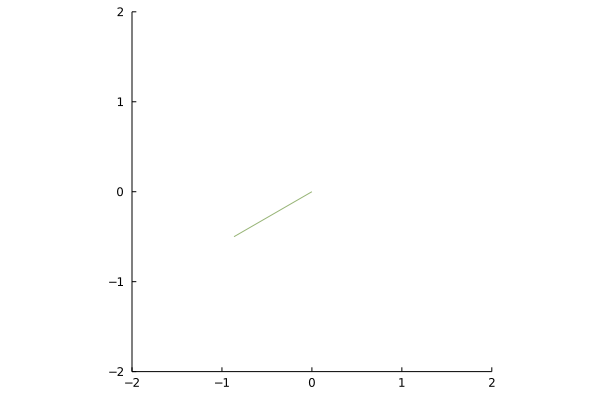

In [24]:
cent = m[1];
α = m[4];
#cent = 0.0 + 0.0*im # change to 0.0 - A*im for flapping using square and triangle waves, otherwise 0.0 + 0.0im
#α = Δα # change to -Δα for flapping using sinusoidal waves, otherwise 0.0
T = RigidTransform(cent,m[4]);
T(body) # transform the body to the current configuration

xlim = (-2.0,2.0)
ylim = (-2.0,2.0)

plot(xlim=xlim, ylim=ylim, body)


In [25]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Umax = 0.25*pi/(2*K*2*a)

Δx = 0.02;
Δt = 0.005;

In [26]:
K = body.len/length(body)/Δx;
@show K
@show body.len
@show length(body)

K = 0.9803921568627451
body.len = 1.0
length(body) = 51


51

# Setting Up the System and Solver

In [33]:
sys = NavierStokes(Re, Δx, xlim, ylim, Δt, X̃ = X̃, 
    isstore = true, 
    isstatic = false, 
    ddftype=CartesianGrids.Yang3, 
    isfilter = false)

Navier-Stokes system on a grid of size 208 x 208

In [63]:
w₀ = Nodes(Dual,size(sys));
u = (w₀,[real(motion(0.0)[1]),imag(motion(0.0)[1]), motion(0.0)[4]])
xg, yg = coordinates(w₀,dx=Δx,I0=origin(sys))
f = (VectorData(X̃),Vector{Float64}());

#f = VectorData(X̃);

In [56]:
using LinearAlgebra
plan_intfact1(t,u) = CartesianGrids.plan_intfact(t,u,sys)
plan_intfact2(t,u) = I
plans = (plan_intfact1,plan_intfact2)    

(plan_intfact1, plan_intfact2)

In [69]:
function ConstrainedSystems.plan_constraints(u::Tuple{Nodes{Dual,NX,NY},Vector{Float64}},t,sys::NavierStokes{NX,NY,N,false}) where {NX,NY,N}

  # for now, just assume that there is only one body. will fix later.

  xc, yc, α = u[2]
  T = RigidTransform((xc,yc),α)
  # should be able to save some time and memory allocation here...
  x, y = T(sys.X̃.u,sys.X̃.v)
  X = VectorData(x,y)
  regop = Regularize(X,cellsize(sys);issymmetric=true,I0=origin(sys))
  if sys._isstore
#     Hmat, Emat = RegularizationMatrix(regop,VectorData{N}(),Edges{Primal,NX,NY}())
    Hmat, Emat = RegularizationMatrix(regop, VectorData(X), Edges(Primal, u[1]))
      
    sys.Hmat = Hmat
    sys.Emat = Emat
    return (f->ConstrainedSystems.B₁ᵀ(f,regop,sys), f->zeros(Float64,size(u[2]))),
           (w->ConstrainedSystems.B₂(w,regop,sys), u->Vector{Float64}())
    #return (f->ConstrainedSystems.B₁ᵀ(f,sys), f->zeros(Float64,size(u[2]))),
    #       (w->ConstrainedSystems.B₂(w,sys), u->Vector{Float64}())
  else
    return (f->ConstrainedSystems.B₁ᵀ(f,regop,sys), f->zeros(Float64,size(u[2]))),
           (w->ConstrainedSystems.B₂(w,regop,sys), u->Vector{Float64}())
  end


end

In [70]:
plan_constraints(u,t) = ConstrainedSystems.plan_constraints(u,t,sys)
ConstrainedSystems.r₁(u,t) = ConstrainedSystems.r₁(u,t,sys,motion)
ConstrainedSystems.r₂(u,t) = ConstrainedSystems.r₂(u,t,sys,motion)
ifherk = IFHERK(u,f,sys.Δt,
                plans,plan_constraints,
                (ConstrainedSystems.r₁,ConstrainedSystems.r₂),rk=ConstrainedSystems.RK31,isstaticconstraints=false)

Order-3 IF-HERK integrator with
   State of type Tuple{Nodes{Dual,208,208,Float64,Array{Float64,2}},Array{Float64,1}}
   Force of type Tuple{VectorData{51,Float64,Array{Float64,1}},Array{Float64,1}}
   Time step size 0.005


# Running the Solver

In [76]:
t = 0.0
w₀ .= 0.0
# u = (deepcopy(w₀),[real(cent),imag(cent),α₀])
u = (deepcopy(w₀),[real(motion(0.0)[1]),imag(motion(0.0)[1]), motion(0.0)[4]])
f = (VectorData(X̃),Vector{Float64}());
fx = Float64[];
fy = Float64[];
kin_hist = []
dp = [];
thist = [];
uhist = [];
tsample = 0.02; # rate at which to store field data
tf = 5;
T = Δt:Δt:tf;

In [77]:
@showprogress for ti in T
    global t, u, f = ifherk(t,u)
    
    push!(thist,t)
    
    fp = deepcopy(f[1])
    fp.u .*= Δx^2
    fp.v .*= Δx^2
    
    push!(dp,fp)
    push!(kin_hist, deepcopy(u[2]))
    
    push!(fx,sum(f[1].u)*Δx^2)
    push!(fy,sum(f[1].v)*Δx^2)

    if (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12))
      push!(uhist, deepcopy(u))
    end

end
println("solution completed through time t = ",t)

LoadError: MethodError: Cannot `convert` an object of type Float64 to an object of type Nodes{Dual,208,208,Float64,Array{Float64,2}}
Closest candidates are:
  convert(::Type{T}, !Matched::T) where T<:AbstractArray at abstractarray.jl:14
  convert(::Type{T}, !Matched::Factorization) where T<:AbstractArray at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/factorization.jl:55
  convert(::Type{T}, !Matched::T) where T at essentials.jl:171

In [73]:
@show kin_hist
@show uhist

kin_hist = Any[]
uhist = Any[]


Any[]

In [75]:
#clibrary(:colorbrewer)
default(clim = (-0.25, 0.25), markerstrokealpha = 0, markersize = 3, grid = false, 
     legend = false, colorbar = :right, colorbar_title = "\$\\Gamma\$")

newanim = @animate for i = 1:length(uhist)
    T = RigidTransform(uhist[i][2])
    T(body)
    plot(xg,yg,uhist[i],levels=range(-0.5,stop=0.5,length=30), color = :RdBu)
    plot!(xlim=xlim, ylim=ylim, body)
end

gif(newanim, "Sinusoid_30_5T.gif") 

LoadError: ArgumentError: Cannot build empty animations

In [29]:
px = plot(thist,2*fy,ylim=(-50,50),xlabel="Convective time",ylabel="CD",legend=false)
py = plot(thist,2*fx,ylim=(-50,50),xlabel="Convective time",ylabel="CL",legend=false)
plot(px,py)

LoadError: UndefVarError: fy not defined

# Obtaining Pressure Distributions

In [30]:
RigidTransform(kin::Kinematics, t) = RigidTransform(kin(t)[1], kin(t)[4])

LoadError: UndefVarError: Kinematics not defined

In [31]:
function diff(b::Body{N}) where {N}
  ip1(i) = 1 + mod(i,N)
  im1(i) = 1 + mod(i-2,N)
  dxtmp = [0.5*(b.x[ip1(i)] - b.x[im1(i)]) for i = 1:N]
  dytmp = [0.5*(b.y[ip1(i)] - b.y[im1(i)]) for i = 1:N]

  if typeof(body) <:Plate
    dxtmp[1] = 0.5*(b.x[2] - b.x[1])
    dxtmp[N] = 0.5*(b.x[N] - b.x[N-1])

    dytmp[1] = 0.5*(b.y[2] - b.y[1])
    dytmp[N] = 0.5*(b.y[N] - b.y[N-1])
  end
  return dxtmp,dytmp
end

LoadError: UndefVarError: Body not defined

In [32]:
ds = sqrt.(diff(body)[1].^2+diff(body)[2].^2);

LoadError: UndefVarError: body not defined

In [33]:
q = Edges(Primal,u[1])
f = VectorData(X)

regop = Regularize(X,Δx;I0=Fields.origin(sys.grid),issymmetric=true)
Hmat, Emat = RegularizationMatrix(regop,f,q)

regopfilt = Regularize(X,Δx;I0=Fields.origin(sys.grid),filter=true,weights=Δx^2)
Ēmat = InterpolationMatrix(regopfilt,q,f)
# Cmat = sparse(Ēmat*Hmat);
P(f) = Ēmat*(Hmat*f)

LoadError: UndefVarError: u not defined

In [34]:
normal(β) = (-sin(β), cos(β))

normal (generic function with 1 method)

In [35]:
function dot(A::Tuple{T,T},B::VectorData) where {T<:Number}
    C = ScalarData(B)
    x, y = A
    C.data .= x*B.u + y*B.v
    return C
end

LoadError: UndefVarError: VectorData not defined

In [36]:
length(kin_hist)

LoadError: UndefVarError: kin_hist not defined

In [37]:
pressure = []
Fn = []
@showprogress for (i, dpi) in enumerate(dp)
    xc, yc, α = kin_hist[i]
#     n = (-sin(α), cos(α))
    
    T = Bodies.RigidTransform((xc,yc),α)
    # should be able to save some time and memory allocation here...
    x, y = T(sys.X̃.u,sys.X̃.v)
    X = VectorData(x,y)
    
    regop = Regularize(X,Δx;I0=Fields.origin(sys.grid),issymmetric=true)
    Hmat, Emat = RegularizationMatrix(regop,f,q)

    regopfilt = Regularize(X,Δx;I0=Fields.origin(sys.grid),filter=true,weights=Δx^2)
    Ēmat = InterpolationMatrix(regopfilt,q,f)

    
    push!(pressure, deepcopy(dot(normal(α), (Ēmat*(Hmat*dpi))) ./(K*Δx)))
    push!(Fn, deepcopy([(-fx*sin(α)+fy*cos(α))]))
end

LoadError: LoadError: UndefVarError: @showprogress not defined
in expression starting at In[37]:3

In [38]:
length(pressure[1])

LoadError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

In [39]:
time = Δt:Δt:tf;

newanim2 = @animate for i = 1:length(kin_hist)
    println(i/length(kin_hist)*100)
    plot(K*body.x̃, pressure[i], ylim = (-20, 20), title = string(string(round(time[i]*fstar*100)/100), " Periods"))
end

gif(newanim2, "Sinusoid_30_5T_p.gif") 

LoadError: UndefVarError: Δt not defined

In [40]:
s = K*body.x̃;
t = time;
p = pressure;

LoadError: UndefVarError: body not defined

In [41]:
@save "Re_200_Sinusoid.jld2" s t p fx fy Fn

LoadError: LoadError: UndefVarError: @save not defined
in expression starting at In[41]:1